In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import thisnotthat as tnt
import panel as pn

zot_df = pd.read_csv('zot_clean.csv')

# Convert the date columns to datetime objects
date_columns = ["Date", "Date Added", "Date Modified"]
for col in date_columns:
    zot_df[col] = pd.to_datetime(zot_df[col], errors='coerce',format="mixed")

zot_df["Publication Year"] = zot_df["Publication Year"].astype("Int64")
zot_df["Hearts"] = zot_df["Hearts"].astype("Int64")

zot_df["Manual Tags"] = zot_df["Manual Tags"].fillna("").str.split(";").apply(lambda tags: [tag.strip() for tag in tags])
zot_df["Common Tags"] = zot_df["Common Tags"].fillna("").str.split(";").apply(lambda tags: [tag.strip() for tag in tags])
zot_df["Common Tags"] = zot_df["Common Tags"].apply(lambda tags : [tag for tag in tags if tag != ""])

#dropping rows without title 
zot_df = zot_df.dropna(subset=['Title'])

# reordering the columns
first_order = ["Title", "Author", "Date", "Abstract Note","Date Added"]
new_order = first_order + [col for col in zot_df.columns.tolist() if col not in first_order]
zot_df = zot_df.reindex(columns=new_order)

# this is for lower case search
zot_df_lowercase = zot_df.copy()
zot_df_lowercase["Title Lower"] = zot_df_lowercase["Title"].str.lower()
zot_df_lowercase["Author Lower"] = zot_df_lowercase["Author"].str.lower()
zot_df_lowercase["Abstract Note Lower"] = zot_df_lowercase["Abstract Note"].str.lower()

#loading computed embeddings
embeddings_df = pd.read_csv('zot_embeddings.csv') 

In [41]:
zot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719 entries, 0 to 718
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Title              719 non-null    object        
 1   Author             656 non-null    object        
 2   Date               719 non-null    datetime64[ns]
 3   Abstract Note      677 non-null    object        
 4   Date Added         719 non-null    datetime64[ns]
 5   Item Type          719 non-null    object        
 6   Publication Year   719 non-null    Int64         
 7   Publication Title  279 non-null    object        
 8   DOI                215 non-null    object        
 9   Url                651 non-null    object        
 10  Date Modified      719 non-null    datetime64[ns]
 11  Volume             205 non-null    float64       
 12  Publisher          325 non-null    object        
 13  Language           584 non-null    object        
 14  Library Ca

In [6]:
import pacmap
pac5 = pacmap.PaCMAP(
    n_components=2,
    n_neighbors=5,
    MN_ratio=0.5,
    FP_ratio=2.0,
    distance="angular",
    random_state=3)

pac7 = pacmap.PaCMAP(
    n_components=2,
    n_neighbors=7,
    MN_ratio=0.5,
    FP_ratio=2.0,
    distance="angular",
    random_state=3)

# 10 sec for 720
zot_pac5 = pac5.fit_transform(np.array(embeddings_df))
zot_pac7 = pac7.fit_transform(np.array(embeddings_df))

d:\program_files\miniconda\envs\zoteromap\Lib\site-packages\pacmap\pacmap.py:822: UserWarning: Warning: random state is set to 3
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


ValueError: The number of projection dimensions must be at least 2.

In [4]:
pd.DataFrame(zot_pac5).to_csv('zot_pac5.csv')
pd.DataFrame(zot_pac7).to_csv('zot_pac7.csv')

NameError: name 'zot_pac5' is not defined

In [3]:
zot_pac5 = np.array(pd.read_csv('zot_pac5.csv',index_col=0))
zot_pac7 = np.array(pd.read_csv('zot_pac7.csv',index_col=0))

In [8]:
print(zot_pac5[:3])
print(zot_pac7[:3])

[[ 4.5892615  -0.38724467]
 [ 4.8193836  -1.3649775 ]
 [ 4.7174706  -1.746284  ]]
[[ 5.126827  -1.0344746]
 [ 4.445411  -1.2958176]
 [ 4.4533825 -1.6716983]]


In [39]:
import numpy as np
import matplotlib.pyplot as plt
import hdbscan

# Assuming zot_pac5 is already defined
# Cluster the data using HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=5,cluster_selection_epsilon=1.4)
clusters = clusterer.fit_predict(np.hstack((zot_pac5,zot_pac7)))

# Convert cluster labels to strings
clusters = [str(label) for label in clusters]

# Print the first 3 elements as strings
print(clusters[:10])

['13', '13', '13', '7', '7', '7', '7', '7', '-1', '11']


In [26]:
zot_df.columns

Index(['Title', 'Author', 'Date', 'Abstract Note', 'Date Added', 'Item Type',
       'Publication Year', 'Publication Title', 'DOI', 'Url', 'Date Modified',
       'Volume', 'Publisher', 'Language', 'Library Catalog', 'Notes',
       'Manual Tags', 'Hearts', 'Common Tags'],
      dtype='object')

Launching server at http://localhost:65195


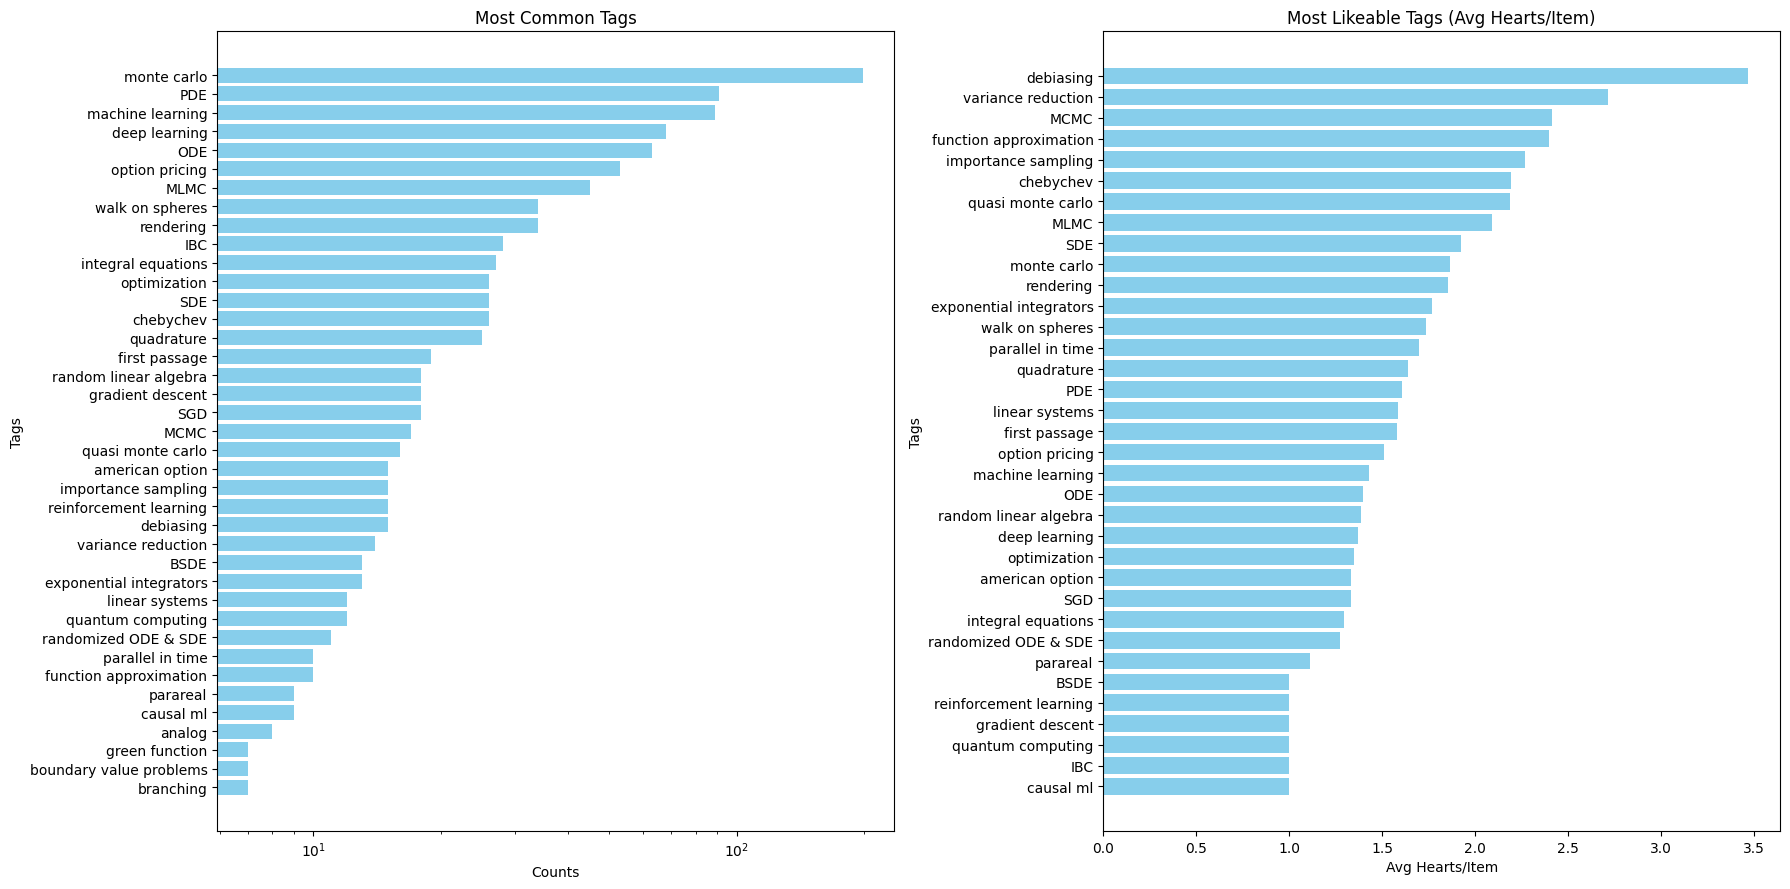

In [41]:
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import matplotlib.pyplot as plt
import panel as pn
import numpy as np


# tabs for pacmap viz
zot_pacs = [zot_pac5, zot_pac7]
plots = []
for zot_pac in zot_pacs:
    plots.append(
        tnt.BokehPlotPane(
            zot_pac,
            hover_text=zot_df["Date"].dt.year.astype(str) + " " + zot_df["Title"],
            marker_size=(zot_df["Hearts"].fillna(0) + 2) / 50,
            labels = clusters, 
            show_legend=False,
            legend_location="top_right",
            sizing_mode='stretch_both',
            min_point_size=0.001,
            max_point_size=0.05,
        )
    )

#tabs using dates
dates = [zot_df["Date Added"], zot_df["Date"]]
scaler = MinMaxScaler()
for date in dates:
    date_num = date.apply(lambda x: x.timestamp()).values.reshape(-1, 1)
    date_scaled = 20 * scaler.fit_transform(date_num)
    plots.append(
        tnt.BokehPlotPane(
            np.column_stack((date_scaled, zot_pac5[:, 0])),
            hover_text=zot_df["Date"].dt.year.astype(str) + " " + zot_df["Title"],
            marker_size=(zot_df["Hearts"].fillna(0) + 2) / 50,
            labels = clusters, 
            show_legend=False,
            legend_location="top_right",
            sizing_mode='stretch_both',
            min_point_size=0.001,
            max_point_size=0.05,
        )
    )
# data view tab
data_view = tnt.SimpleDataPane(
    zot_df,
    sizing_mode="stretch_both", max_rows=9999, max_cols=50)

data_view_simple = tnt.SimpleDataPane(
    zot_df[["Title", "Author", "Date", "Abstract Note"]],
    sizing_mode="stretch_both", max_rows=9999, max_cols=50)

# linking the tabs
for i in range(1, len(plots)):
    plots[i].link(
        plots[0],
        selected="selected",
        bidirectional=True
    )

data_view.link(
    plots[0],
    selected="selected",
    bidirectional=True
)

data_view_simple.link(
    plots[0],
    selected="selected",
    bidirectional=True
)
# tag selector
tag_legend = tnt.TagWidget(zot_df["Common Tags"] + zot_df["Hearts"].fillna(0).apply(lambda x: [(str(x) if x != 0 else "?") + " likeability"]))
tag_legend.link_to_plot(plots[0])

tabs = [pn.Row(plot, tag_legend, name=name) for plot, name in zip(plots, ["pac5", "pac7", "Date Added", "Date"])]


# tags stats tab, just a plot
# Flatten the list of tags
all_tags = [tag for sublist in zot_df["Manual Tags"] for tag in sublist if tag != ""]

# Count the occurrences of each tag
tag_counts = Counter(all_tags)

total_tags = sum(tag_counts.values())

# Filter out tags that are less than 0.5% of the total
filtered_tag_counts = {tag: count for tag, count in tag_counts.items() if count / total_tags >= 0.005}

# Sort the tags by frequency
sorted_tag_counts = dict(sorted(filtered_tag_counts.items(), key=lambda item: item[1], reverse=True))

# Create a figure with 2 subplots
plt.figure(figsize=(18, 9))

# First subplot: Most Common Tags
plt.subplot(1, 2, 1)
plt.barh(list(sorted_tag_counts.keys())[::-1], list(sorted_tag_counts.values())[::-1], color='skyblue')
plt.xlabel('Counts')
plt.ylabel('Tags')
plt.title('Most Common Tags')
plt.xscale('log')
plt.tight_layout()

# Flatten the list of tags and their corresponding hearts
all_tags = [(tag, hearts) for tags, hearts in zip(zot_df["Manual Tags"], zot_df["Hearts"].fillna(1)) for tag in tags if tag != ""]

# Sum the hearts for each tag
tag_hearts = Counter()
for tag, hearts in all_tags:
    tag_hearts[tag] += hearts

# Divide the total hearts by the frequency of each tag
weighted_tag_counts = {tag: tag_hearts[tag] / count for tag, count in tag_counts.items() if count >= 9}

# Sort the tags by frequency
sorted_tag_counts = dict(sorted(weighted_tag_counts.items(), key=lambda item: item[1], reverse=True))

# Second subplot: Most Likeable Tags (Avg Hearts/Item)
plt.subplot(1, 2, 2)
plt.barh(list(sorted_tag_counts.keys())[::-1], list(sorted_tag_counts.values())[::-1], color='skyblue')
plt.xlabel('Avg Hearts/Item')
plt.ylabel('Tags')
plt.title('Most Likeable Tags (Avg Hearts/Item)')
plt.tight_layout()

# Convert the plot to a Panel object
tag_plot = pn.pane.Matplotlib(plt.gcf(), sizing_mode='stretch_both')

app = pn.Tabs(
    *tabs,
    pn.Column(data_view_simple, name="data simple"),
    pn.Column(tag_plot, name="tags stats"),
    pn.Column(data_view, name="data all"))

# add simple search
simplesearch = tnt.SimpleSearchWidget(plots[0], raw_dataframe=zot_df_lowercase)
app = pn.Column(simplesearch, app)

pn.serve(app)